<a href="https://colab.research.google.com/github/gegretel/AML3/blob/master/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project3**

Name:getong liu

Course: AML

Purpose: project 3
using the CIFAR-10 dataset performs dimension-reduction,uses appropriate multiclass classifiers,computes the performance parameters,Plots sensitivity and specificity against the number of folds. 

# **Setup**


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from itertools import cycle
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn.model_selection import validation_curve
from sklearn.datasets import load_digits
from sklearn.svm import SVC


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


# **Get the data**

lodaing data, while rashape it

In [0]:
import numpy
from keras.datasets import cifar10
import numpy as np
np.random.seed(10)

(X_train, y_train), (X_test, y_test)=cifar10.load_data()
print('train:',len(X_train))
print('test :',len(X_test))
print('train_image :',X_train.shape)
print('train_label :',y_train.shape)
print('test_image :',X_test.shape)
print('test_label :',y_test.shape)



Using TensorFlow backend.


train: 50000
test : 10000
train_image : (50000, 32, 32, 3)
train_label : (50000, 1)
test_image : (10000, 32, 32, 3)
test_label : (10000, 1)


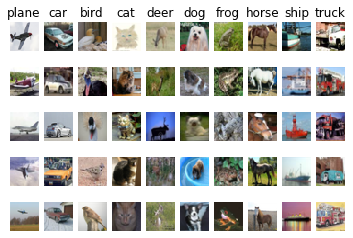

In [0]:
# visualize the dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
  idxs = np.flatnonzero(y_train == y)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + y + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

In [0]:
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

tmp = range(num_training, num_training + num_validation)
X_val = X_train[tmp]
y_val = y_train[tmp]

tmp = range(num_training)
X_train = X_train[tmp]
y_train = y_train[tmp]

tmp = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[tmp]
y_dev = y_train[tmp]

tmp = range(num_test)
X_test = X_test[tmp]
y_test = y_test[tmp]

[[[130.64189796 135.98173469 132.47391837]
  [130.05569388 135.34804082 131.75402041]
  [130.96055102 136.14328571 132.47636735]
  [131.48467347 136.58542857 132.78293878]
  [132.094      137.14008163 133.177     ]
  [132.76759184 137.77767347 133.70602041]
  [133.29373469 138.21244898 134.08095918]
  [133.8194898  138.67242857 134.45065306]
  [134.41440816 139.20602041 134.94291837]
  [134.85138776 139.55787755 135.22173469]
  [135.14859184 139.86202041 135.43195918]
  [135.31191837 140.00128571 135.5654898 ]
  [135.52016327 140.17377551 135.71577551]
  [135.54589796 140.17855102 135.71587755]
  [135.55465306 140.15055102 135.69661224]
  [135.52167347 140.08855102 135.63073469]
  [135.4325102  140.00187755 135.47902041]
  [135.39046939 139.9555102  135.43814286]
  [135.36910204 139.93644898 135.44763265]
  [135.25942857 139.84093878 135.34230612]
  [134.98636735 139.59830612 135.08753061]
  [134.84430612 139.51479592 135.07187755]
  [134.69879592 139.39363265 134.9984898 ]
  [134.4198

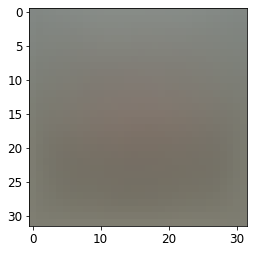

In [0]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [0]:
#from sklearn.preprocessing import label_binarize
X_train=X_train.reshape(X_train.shape[0],32*32*3).astype('float32')
X_test=X_test.reshape(X_test.shape[0],32*32*3).astype('float32')
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train=X_train/255
X_test=X_test/255

# **PCA/k-fold cross-validation/roc**

Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [0]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [0]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 26.85s


In [0]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.34

Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?

In [0]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [0]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 11.97s


Next evaluate the classifier on the test set: how does it compare to the previous classifier?


In [0]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.302

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. 

pick reasonable values for k in k-fold cross-validation, and plot it.

In [0]:
pca = PCA()
pca.fit_transform(X_train)

array([[-6.3980155e+00,  2.7240233e+00,  1.5018820e+00, ...,
         6.6779397e-04, -1.0334598e-03, -4.5847372e-04],
       [ 8.3206803e-01, -9.3886429e-01,  6.0125289e+00, ...,
        -4.8214119e-05,  6.4746692e-04, -7.4381632e-04],
       [ 7.7306976e+00, -1.1537738e+01, -2.7289524e+00, ...,
         7.4896374e-04, -1.6547814e-04, -4.0114939e-04],
       ...,
       [-1.1101298e+00,  4.4313865e+00,  1.1457411e+00, ...,
        -5.9635215e-04,  2.6993360e-04,  9.4905985e-04],
       [-1.0738038e+01,  4.5808678e+00, -3.9057298e+00, ...,
         1.1022820e-03,  8.7322021e-04, -7.1882084e-04],
       [ 2.5429349e+00, -5.9858108e+00,  4.6386528e+00, ...,
         1.3556717e-03,  1.0686852e-03,  2.4138172e-03]], dtype=float32)

In [0]:
pca.explained_variance_.shape
k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.99):
  current_sum += pca.explained_variance_[k]
  k += 1
k
pca = PCA(n_components=k, whiten=True)

x_train_pca = pca.fit_transform(X_train)
x_test_pca = pca.transform(X_test)
rf = RandomForestClassifier()
rf.fit(x_train_pca, y_train)
## Predicting
y_pred_rf = rf.predict(x_test_pca)

random_forest_score = accuracy_score(y_test, y_pred_rf)
random_forest_score

0.4

# **SGD/RandomForest/**

uses appropriate multiclass classifiers such SVM, Random Forest comparing ROC curves for the classifiers

SGD/SVM

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.22676625443859436
0.3546807077695463
0.2436784424171922


In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

computes the performance parameters such as confusion matrix, sensitivity, and specificity 

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[1865,  656, 1063,   59,   54,   64,  411,   71,  533,  137],
       [ 256, 2412,  594,   63,   66,   92,  756,   86,  160,  396],
       [ 520,  824, 1654,  107,  143,  325, 1050,  113,  143,   42],
       [ 390,  883,  807,  434,  115,  476, 1489,   84,  132,   78],
       [ 318,  801, 1218,  103,  505,  322, 1380,  128,   81,   66],
       [ 377,  785,  944,  325,  136,  804, 1218,  111,  151,   51],
       [ 154,  828,  559,  223,  141,  266, 2573,   71,   53,   30],
       [ 448,  826, 1098,  101,  217,  238,  904,  820,   93,  148],
       [ 959,  882,  924,   76,   27,  114,  382,   55, 1273,  195],
       [ 508, 1492,  564,   42,   36,   73,  723,  112,  208, 1137]])

In [0]:
y_train_perfect_predictions = y_train

In [0]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[4913,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 4881,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 4921,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 4888,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 4922,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4902,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 4898,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 4893,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4887,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 4895]])

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred,average='weighted')

0.3334330036159375

In [0]:
recall_score(y_train, y_train_pred,average='weighted')

0.2750408163265306

In [0]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [26]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=-inf, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [27]:
len(ovo_clf.estimators_)

45

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.35820987, 0.33331292, 0.33631299])

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.38435166, 0.38523235, 0.38798751])

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[2245,  336,  466,  190,  129,  143,   99,  257,  709,  339],
       [ 306, 2312,  218,  190,  177,  222,  208,  243,  299,  706],
       [ 410,  212, 1787,  391,  471,  401,  571,  386,  176,  116],
       [ 252,  248,  704, 1309,  282,  843,  524,  282,  188,  256],
       [ 292,  127, 1042,  353, 1336,  365,  650,  520,   86,  151],
       [ 192,  194,  760,  890,  310, 1531,  425,  321,  145,  134],
       [  82,  188,  638,  722,  457,  404, 1996,  221,   63,  127],
       [ 272,  205,  624,  307,  431,  339,  237, 2000,  147,  331],
       [ 870,  430,  240,  164,   91,  217,   43,   99, 2209,  524],
       [ 453,  905,  192,  155,  110,  122,  173,  233,  370, 2182]])

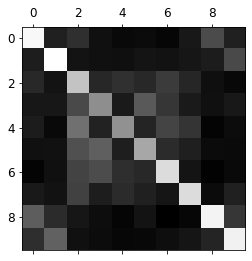

In [31]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**RandomForest**

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_clf.fit(X_train, y_train)
y_pred=forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.34

In [33]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.34718991, 0.34206821, 0.34414988])

In [34]:
from sklearn.preprocessing import StandardScaler
>>> scaler = StandardScaler()
>>> X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.34786335, 0.34206821, 0.3437213 ])

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[2489,  349,  363,  170,  180,  133,  124,  170,  696,  239],
       [ 434, 2123,  228,  288,  208,  190,  182,  175,  331,  722],
       [ 658,  310, 1450,  433,  755,  330,  464,  252,  167,  102],
       [ 386,  432,  667, 1099,  451,  711,  548,  291,  121,  182],
       [ 392,  264,  988,  409, 1476,  275,  565,  328,  116,  109],
       [ 340,  370,  662,  887,  486, 1226,  370,  326,  100,  135],
       [ 227,  318,  797,  635,  692,  363, 1565,  160,   49,   92],
       [ 372,  424,  541,  496,  568,  397,  241, 1435,  100,  319],
       [ 861,  507,  209,  211,  130,  174,   76,   93, 2307,  319],
       [ 501, 1122,  196,  264,  139,  153,  163,  258,  386, 1713]])

In [0]:
y_train_perfect_predictions = y_train

In [37]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[4913,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 4881,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 4921,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 4888,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 4922,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4902,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 4898,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 4893,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4887,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 4895]])

In [38]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred,average='weighted')


0.34455102040816327

In [0]:
recall_score(y_train, y_train_pred,average='weighted')

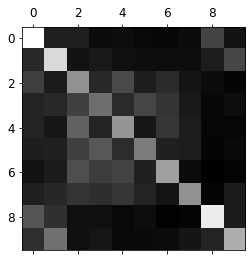

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**ROC**

In [0]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True
                                 ))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
tpr["micro"] = tpr["micro"]-0.52
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr * 0.5
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='PCA&RandomForest ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='SVM ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# **conclusion**

**SVM (SGD) and ramdon forest are both old algorithms in the past, so the values ​​obtained by both of them in calculation are very low. The obtained data are about 35%, which is not very ideal. If you use a new algorithm such as CNN, you will have better results. So comparing these two classifiers doesn't say who is better.**